In [1]:
import networkx as nx
import numpy as np
import osmnx as ox
import functions

In [2]:
def path_finder(initial_node, final_node , G ):
    
    """
    This functions simulates an agent thar looks for the best path to follow from one node to another
    """

    # get dictionary with geocordinates of each of the nodes
    coordiantes = functions.get_geo_coordinates(G)

    node_i = initial_node 

    # to store the routes:
    route= {}

    path = []

    # bug list
    bug_list = []

    # no exit list 
    no_exit_list = []

    # loop to finde the path: 
    while node_i != final_node:

        # store all nodes the agent pass through: 
        path.append(node_i)
    
        # measure the angle and distnac between the node_i and the destination node
        angle_i = functions.get_angle( coordiantes[ node_i ], coordiantes[ final_node] )
        dist_i = functions.get_distance( coordiantes[ node_i ], coordiantes[ final_node] ) 

        # get the neighbours of the node. The neighbours are directed nodes
        neighbors = list(G.neighbors(node_i))

        # get probality of pick a given neighbour
        factors = {}

        for node in neighbors :
            # measure angle and dist of neighbors towards final node 
            angle_neighbor = functions.get_angle( coordiantes[ node ], coordiantes[ final_node] )
            dist_neighbor = functions.get_distance( coordiantes[ node ], coordiantes[ final_node] )
        
            # calculate the probability of picking a node 
            factors[node] = functions.get_factor(dist_neighbor , angle_neighbor , dist_i , angle_i , 0.6, 0.4 )

        # get probabilities
        proba_dic = functions.get_probability(factors)


        print("estoy en el nodo  ", node_i, " mis opciones son : ", proba_dic)

        # list of probable nodes_id: 
        list_proba = list(proba_dic.keys())

        # contador de veces que paso por un nodo 
        repeticions = path.count(node_i)

        for node in list_proba:
            counter = path.count(node)
            if node in path:
                proba_dic[node] = proba_dic[node]*0.4
                if counter > 2:
                    proba_dic[node] = proba_dic[node]*(0.4**counter)


        # if i have pass more than two times by a node 
        if repeticions > 2:
        
            # sotre node_i in wich bug is produced 
            bug_node = node_i
            bug_list.append(node_i)
            print("bugg en el nodo : " , bug_node )

            # count how many times a bug node has been pass through.
            counter = bug_list.count(node_i)

            if counter >= 3:
                vecinos_i = list(G.neighbors(node_i))
                for vecino in vecinos_i:
                    if vecino in  bug_list:
                        route[bug_node][vecino] = 0.0
                        proba_dic[vecino] = route[bug_node][vecino]
                        print("me quedo en el nodo: " , node_i, "acualice probabiliades: ", proba_dic)
                        #print(route)
                #break
        
        # check for node with no exit i.e no neighbors 
        if len(neighbors) == 0:
            # store in route 
            print("estoy en el nodo " , node_i , "no hay salida")
            no_exit_node = node_i
            route[no_exit_node] = {}
            no_exit_list.append(no_exit_node)

            # acutalizo la posicion al nodo anterior
            node_i= path[-2]

            # check neihbours
            vecino_j = list(G.neighbors(node_i))

            # acualizo la proabilidad de volver al nodo sin salida a 0
            for vecino in vecino_j:
                if vecino in no_exit_list:
                    route[node_i][no_exit_node] = 0.0
                    proba_dic = route[node_i]
                    print("volvi al nodo: ", node_i, "se acutliazo las lista de probilidades a : " ,proba_dic)
            #break
                
        # check if the node has no posible routes to the destination
        no_options = all( options == 0 for options in proba_dic.values())       
        if no_options:
            position = path.index(node_i)
            no_options_node = node_i
            no_exit_list.append(node_i)
            print("ninguno de los caminos posibles es correcto")
            print("regreso al nodo", path[position - 1 ])
            node_i =  path[position - 1 ]
            route[node_i][no_options_node] = 0.0
            proba_dic = route[node_i]
        
            # checkear que no vuelva a una ruta sin salida: 
            vecino_z = vecino_j = list(G.neighbors(node_i))
            for vecino in vecino_z:
                if vecino in no_exit_list:
                    position_i = path.index(node_i)
                    node_j = path[position_i -1]
                    print("debo regresar al node " , node_j, " no debo ir a ", node_i)
                    route[node_j][node_i] = 0.0
                    proba_dic = route[node_j]
                    print(proba_dic)
            #break

        # stop simulation if bug 
        if repeticions > 15:
            print(" ERROR: el nodo " , node_i ," se repite mas de 15 veces")
            break

        # add to route:
        route[node_i] = proba_dic
    
        # ge the node id with max probability
        node_id = max(proba_dic , key= proba_dic.get)

        # get the max probability    
        Proba = proba_dic[node_id]
        
        print("estoy en el nodo: " , node_id)

        # update position
        node_i = node_id

    route[final_node] = {final_node:1.0}

    return route, path


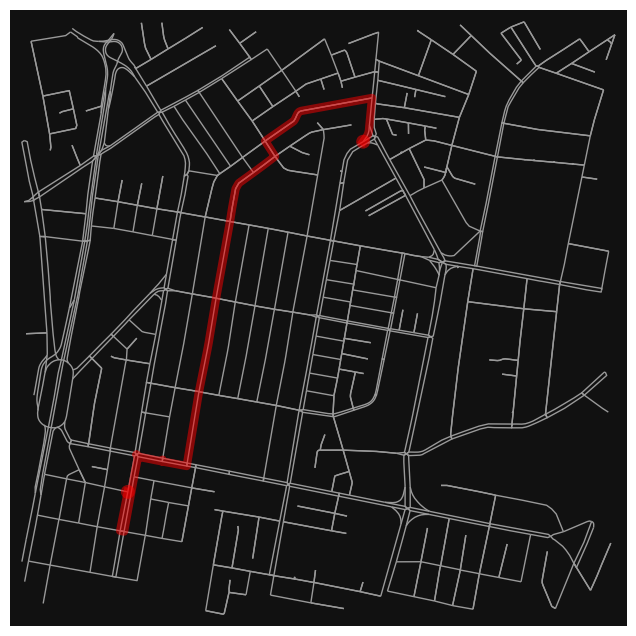

In [3]:
# This location is 1 km round the location : 
G = ox.project_graph(ox.graph_from_point((-0.16509, -78.47888 ), dist=1000, network_type='drive'))
G = ox.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True)

# get data frame
df = nx.to_pandas_edgelist( G )

# plotting the shotrtest path given by netwrokX 
functions.plot_node( 52, 244 , G )

In [4]:
route , path = path_finder(52 , 244 , G)

estoy en el nodo   52  mis opciones son :  {53: 0.5292863128066543, 54: 0.4707136871933458}
estoy en el nodo:  53
estoy en el nodo   53  mis opciones son :  {124: 0.5308605330445774, 116: 0.46913946695542263}
estoy en el nodo:  124
estoy en el nodo   124  mis opciones son :  {115: 0.3375497565838433, 123: 0.36203804191158, 114: 0.3004122015045767}
estoy en el nodo:  123
estoy en el nodo   123  mis opciones son :  {124: 0.4775981569667301, 125: 0.5224018430332699}
estoy en el nodo:  125
estoy en el nodo   125  mis opciones son :  {140: 0.4997702155664492, 141: 0.5002297844335507}
estoy en el nodo:  141
estoy en el nodo   141  mis opciones son :  {364: 1.0}
estoy en el nodo:  364
estoy en el nodo   364  mis opciones son :  {345: 0.4695665990814849, 142: 0.5304334009185152}
estoy en el nodo:  142
estoy en el nodo   142  mis opciones son :  {86: 0.43082674611699023, 140: 0.25109591969962525, 345: 0.31807733418338463}
estoy en el nodo:  86
estoy en el nodo   86  mis opciones son :  {346: 0.

In [5]:
path

[52,
 53,
 124,
 123,
 125,
 141,
 364,
 142,
 86,
 346,
 347,
 44,
 40,
 39,
 43,
 42,
 81,
 80,
 76,
 79,
 235]

In [6]:
#get list of nodes
# get traffic ligths matrix 
matriz = functions.matriz_de_semaforos()
list_nodes = list(G.nodes)
len(list_nodes)

i , f  = functions.choose_route(list_nodes , matriz, G)

i ,f 

(336, 357)

In [7]:
route , path = path_finder(i , f , G)

estoy en el nodo   336  mis opciones son :  {335: 0.45585226299766657, 339: 0.5441477370023333}
estoy en el nodo:  339
estoy en el nodo   339  mis opciones son :  {337: 0.29187145698259725, 367: 0.30849320126711244, 310: 0.39963534175029025}
estoy en el nodo:  310
estoy en el nodo   310  mis opciones son :  {250: 0.3751127418855849, 308: 0.6248872581144151}
estoy en el nodo:  308
estoy en el nodo   308  mis opciones son :  {309: 0.1290457050536052, 310: 0.13170972917468232, 301: 0.7392445657717124}
estoy en el nodo:  301
estoy en el nodo   301  mis opciones son :  {299: 0.13331430854237003, 308: 0.0540482661216469, 358: 0.2027578289476224, 315: 0.6098795963883606}
estoy en el nodo:  315
estoy en el nodo   315  mis opciones son :  {357: 0.976328693982014, 313: 0.009982141125727984, 301: 0.013689164892258123}
estoy en el nodo:  357
